In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
data = pd.read_csv("../data/credit_data_train.csv")

In [3]:
data.head()

,sex,marital_status,current_account_balance,loan_duration,credit_history,loan_purpose,loan_value,savings_account_balance,length_of_employment,instalment_rate,...,length_of_residence,most_valuable_asset,age,other_debt_obligations,home_ownership,existing_credits,employment,num_dependants,citizenship,class
0,Female,non-single,No current account,22,Existing credits paid back,new car,1050.0,Unknown/No savings account,4-7 years,4,...,4,Savings Account/Life Insurance,25.0,NaN,Rent,0,Professionals,1,non-UK,0
1,Male,single,No current account,12,Existing credits paid back,new car,1900.0,Unknown/No savings account,>= 7 years,4,...,3,Car or Other,50.0,NaN,Own,0,Professionals,1,non-UK,0
2,Female,non-single,>= 160 GBP,21,Existing credits paid back,new car,2350.0,80 - 400 GBP,1-4 years,1,...,1,Car or Other,28.0,Bank,Own,0,Experienced professionals,1,non-UK,0
3,Female,non-single,< 0 GBP,6,Existing credits paid back,used car,1100.0,400 - 800 GBP,Unemployed,1,...,2,Savings Account/Life Insurance,23.0,NaN,Rent,0,Unemployed,1,non-UK,0
4,Female,non-single,< 0 GBP,18,Existing credits paid back,electronics,2550.0,< 80 GBP,1-4 years,2,...,2,Real Estate,24.0,NaN,Own,0,Professionals,1,non-UK,1


In [4]:
categorical_cols = data.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['sex', 'marital_status', 'current_account_balance', 'credit_history',
       'loan_purpose', 'savings_account_balance', 'length_of_employment',
       'debtor_status', 'most_valuable_asset', 'other_debt_obligations',
       'home_ownership', 'employment', 'citizenship'],
      dtype='object')


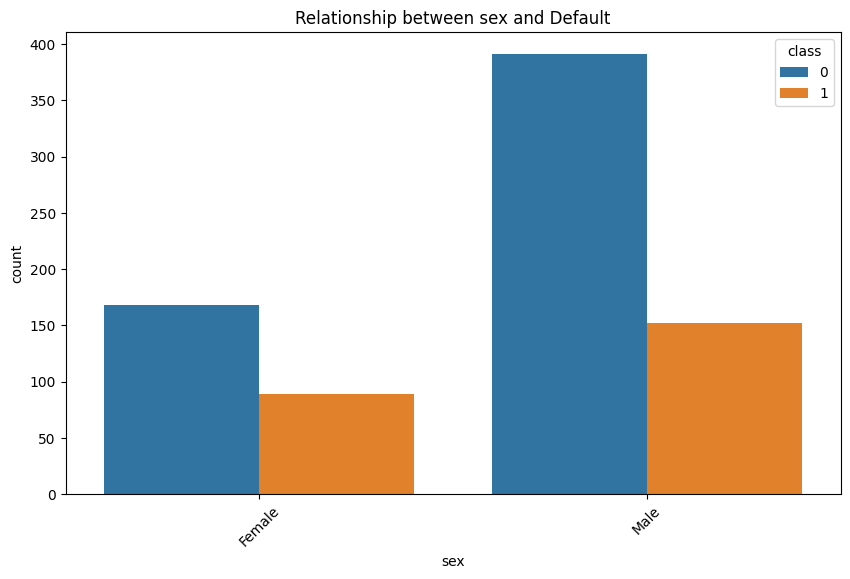

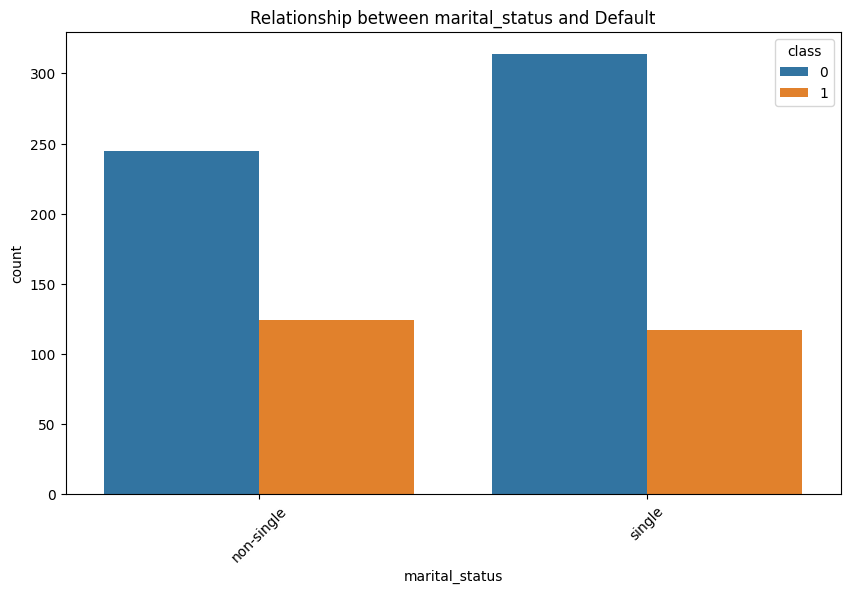

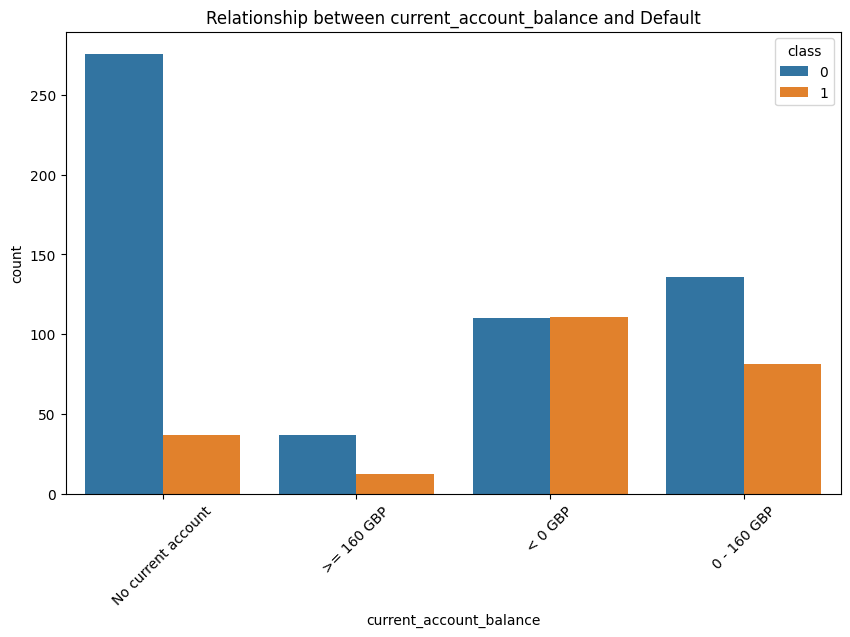

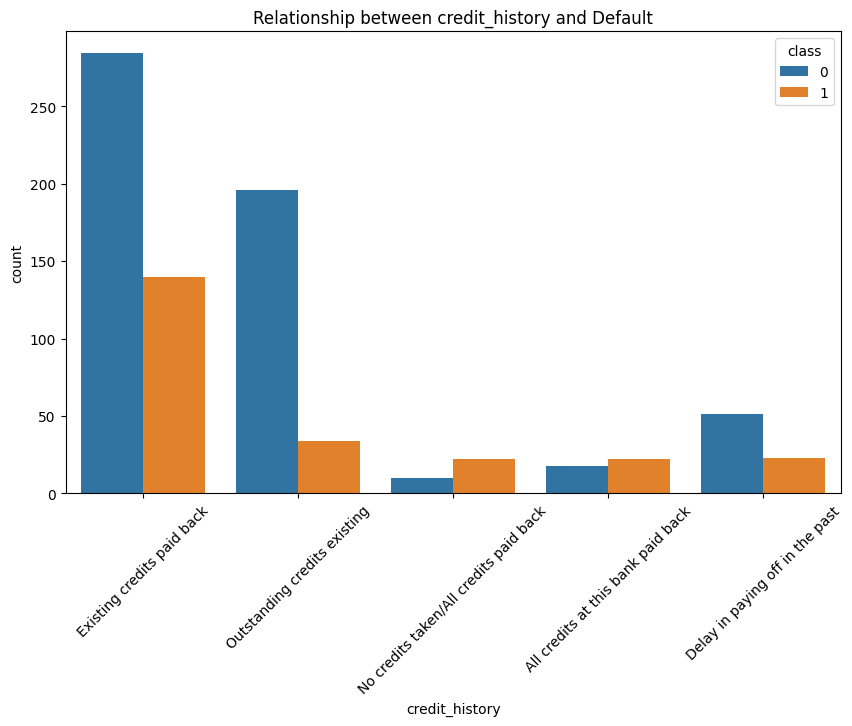

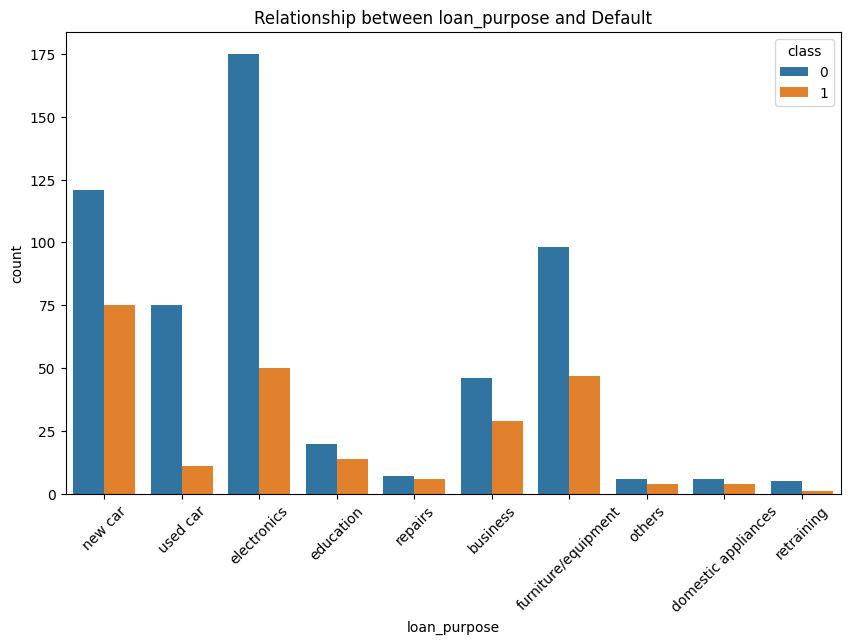

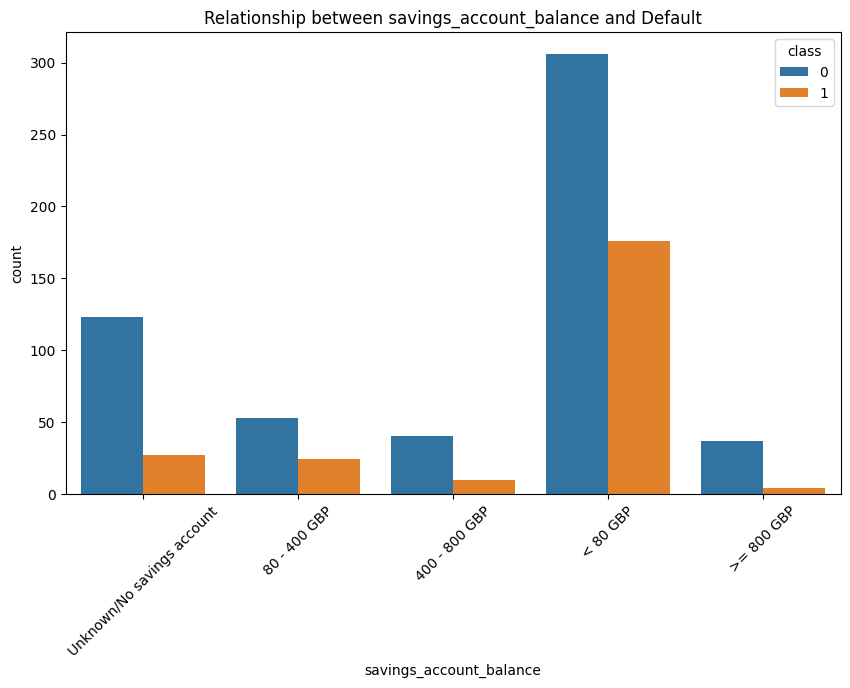

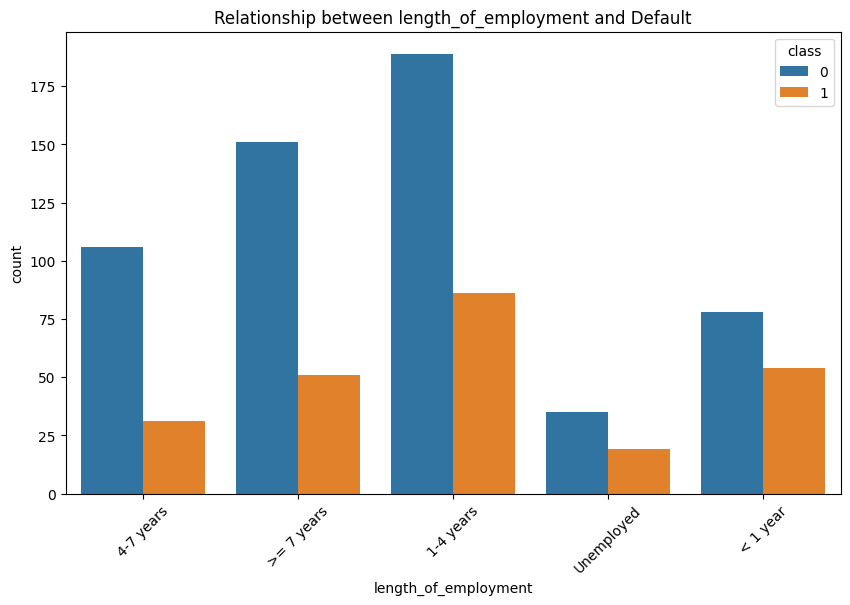

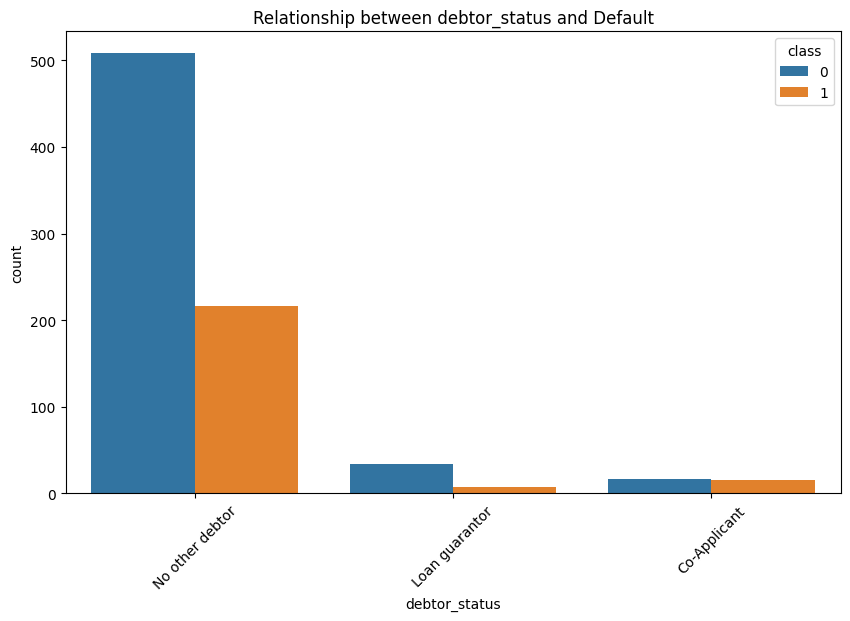

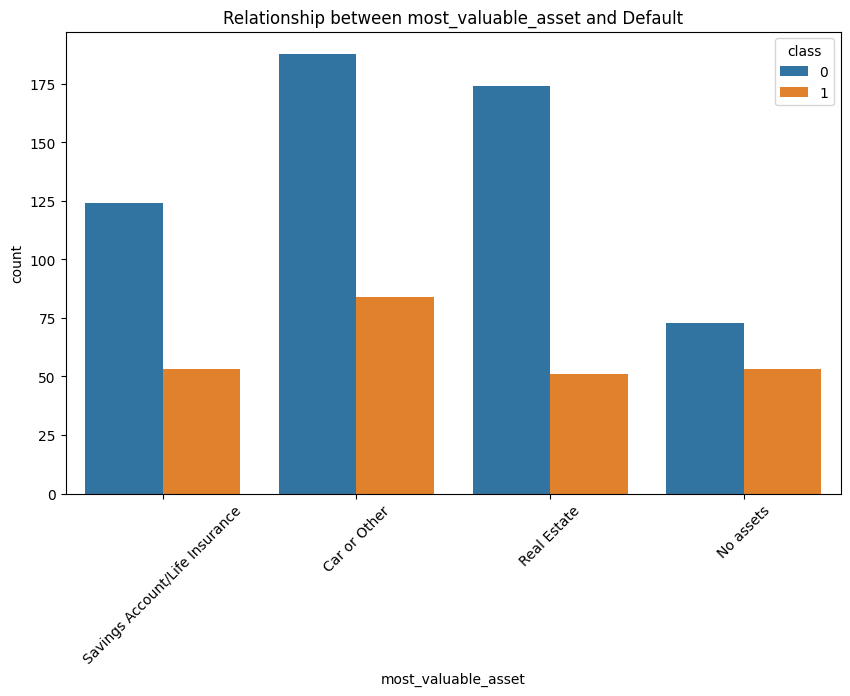

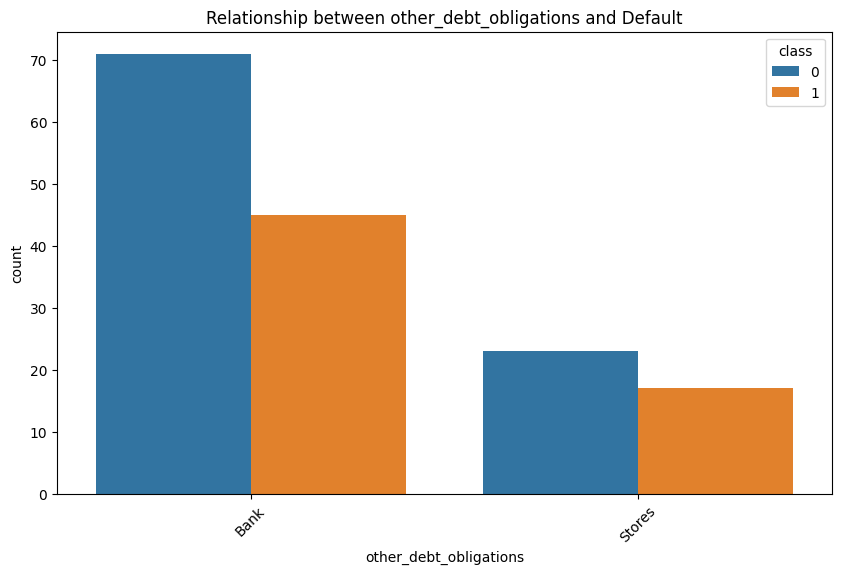

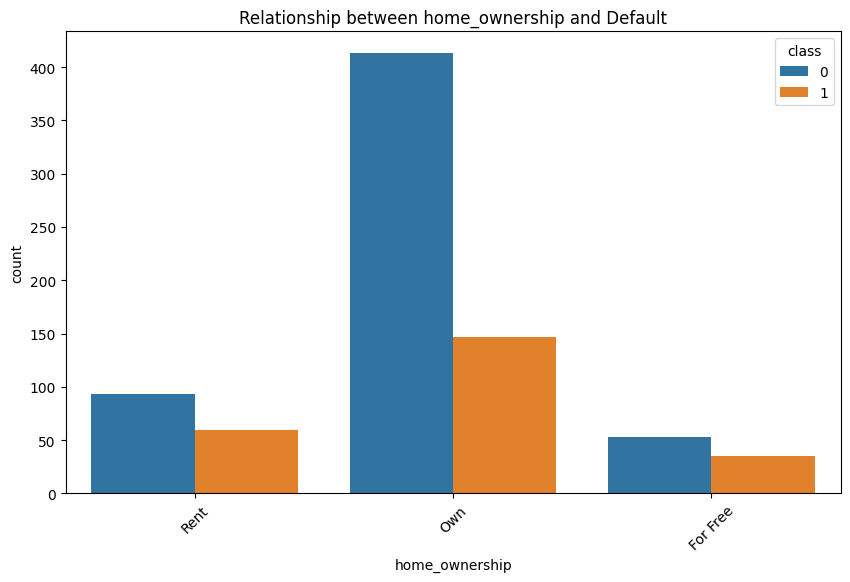

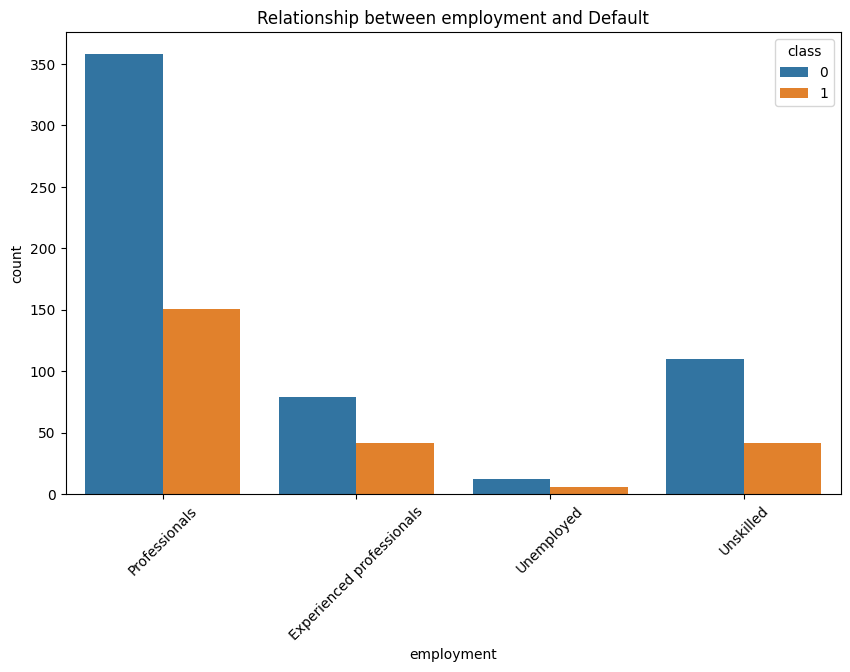

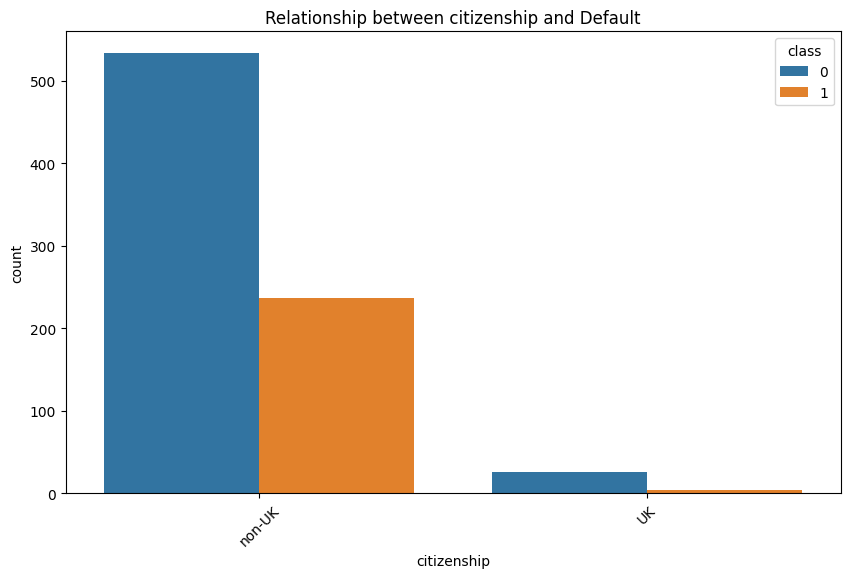

In [5]:
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=col, hue='class')
    plt.title(f'Relationship between {col} and Default')
    plt.xticks(rotation=45)
    plt.show()

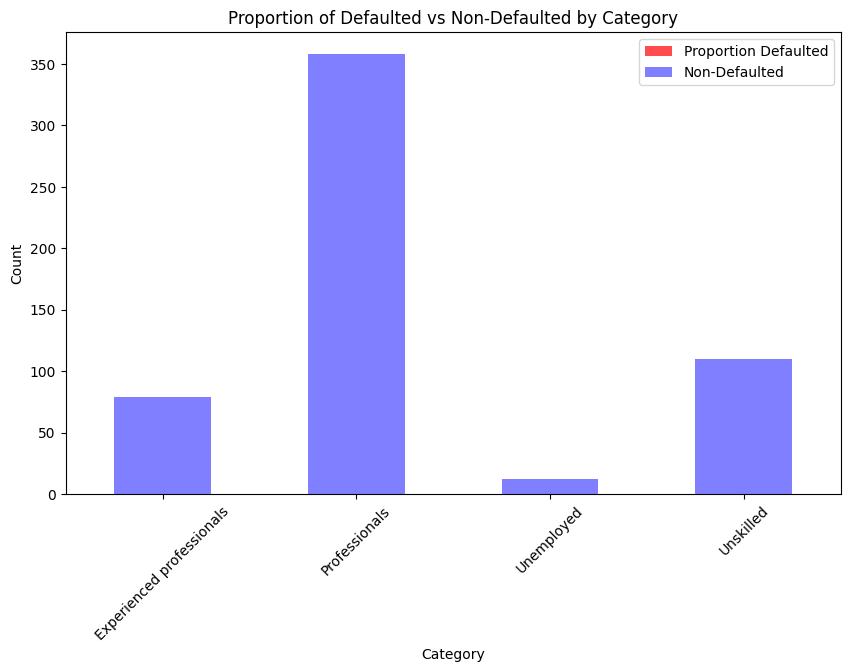

In [6]:
category_counts = data.groupby(['employment', 'class']).size().unstack()
category_counts['proportion_defaulted'] = category_counts[1] / (category_counts[0] + category_counts[1])
fig, ax = plt.subplots(figsize=(10, 6))
category_counts['proportion_defaulted'].plot(kind='bar', ax=ax, color='red', alpha=0.7, label='Proportion Defaulted')
category_counts[0].plot(kind='bar', ax=ax, color='blue', alpha=0.5, label='Non-Defaulted')

ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Proportion of Defaulted vs Non-Defaulted by Category')
ax.legend()

plt.xticks(rotation=45)
plt.show()

In [7]:
unique_values_dict = {}

for col in categorical_cols:
    unique_values = data[col].unique()
    unique_values_dict[col] = unique_values

In [8]:
for col, unique_values in unique_values_dict.items():
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'sex': ['Female' 'Male']
Unique values in 'marital_status': ['non-single' 'single']
Unique values in 'current_account_balance': ['No current account' '>= 160 GBP' '< 0 GBP' '0 - 160 GBP']
Unique values in 'credit_history': ['Existing credits paid back' 'Outstanding credits existing'
 'No credits taken/All credits paid back'
 'All credits at this bank paid back' 'Delay in paying off in the past']
Unique values in 'loan_purpose': ['new car' 'used car' 'electronics' 'education' 'repairs' 'business'
 'furniture/equipment' 'others' 'domestic appliances' 'retraining']
Unique values in 'savings_account_balance': ['Unknown/No savings account' '80 - 400 GBP' '400 - 800 GBP' '< 80 GBP'
 '>= 800 GBP']
Unique values in 'length_of_employment': ['4-7 years' '>= 7 years' '1-4 years' 'Unemployed' '< 1 year']
Unique values in 'debtor_status': ['No other debtor' 'Loan guarantor' 'Co-Applicant']
Unique values in 'most_valuable_asset': ['Savings Account/Life Insurance' 'Car or Other' 'Rea

In [9]:
ordinal_feature_orders = {
    'current_account_balance': ['< 0 GBP','No current account', '0 - 160 GBP', '>= 160 GBP'],
    'credit_history': ['Outstanding credits existing',  'Delay in paying off in the past', 'No credits taken/All credits paid back', 'All credits at this bank paid back', 'Existing credits paid back'],
    'savings_account_balance' : ['Unknown/No savings account', '< 80 GBP', '80 - 400 GBP', '400 - 800 GBP', '>= 800 GBP'],
    'length_of_employment': ['Unemployed', '< 1 year', '1-4 years', '4-7 years', '>= 7 years'],
    'most_valuable_asset' : ['No assets', 'Savings Account/Life Insurance', 'Car or Other', 'Real Estate'],
    'home_ownership' : ['Own', 'Rent', 'For Free'],
    'employment': ['Unemployed', 'Unskilled', 'Professionals', 'Experienced professionals']                             
}

ordinal_encoders = [
    (col, OrdinalEncoder(categories=[order]), [col])
    for col, order in ordinal_feature_orders.items()
]

In [10]:
categorical_columns = list(set(categorical_cols) - set(ordinal_feature_orders.keys()))
ordinal_columns = list(ordinal_feature_orders.keys())
numerical_columns = list(set(data.columns) - set(categorical_cols))

In [11]:
data.columns

Index(['sex', 'marital_status', 'current_account_balance', 'loan_duration',
       'credit_history', 'loan_purpose', 'loan_value',
       'savings_account_balance', 'length_of_employment', 'instalment_rate',
       'debtor_status', 'length_of_residence', 'most_valuable_asset', 'age',
       'other_debt_obligations', 'home_ownership', 'existing_credits',
       'employment', 'num_dependants', 'citizenship', 'class'],
      dtype='object')

In [12]:
numerical_columns.remove('class')
numerical_columns

['age',
 'num_dependants',
 'instalment_rate',
 'existing_credits',
 'length_of_residence',
 'loan_duration',
 'loan_value']

In [13]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]


In [14]:
ordinal_transformers = FeatureUnion(ordinal_encoders)

ordinal_pipeline = Pipeline([
    ('selector', ColumnSelector(ordinal_columns)),
    ('ordinal_encoder', ColumnTransformer(
        transformers=ordinal_encoders,
        remainder='passthrough'
    ))
])

numerical_pipeline = Pipeline([
    ('selector', ColumnSelector(numerical_columns)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('selector', ColumnSelector(categorical_columns)),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_pipeline, ordinal_columns),
        ('numerical', numerical_pipeline, numerical_columns),
        ('categorical', categorical_pipeline, categorical_columns)
    ], remainder='passthrough'
)

In [15]:
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [16]:
# y = data['class']
# X_processed = preprocessing_pipeline.fit_transform(data.drop('class', axis=1))

In [18]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

In [19]:
X = data.drop('class', axis=1)
y = data['class']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

In [21]:
X_train_processed = preprocessor.transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [26]:
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)

In [27]:
models,predictions = clf.fit(X_train_processed, X_test_processed, y_train, y_test)

 31%|██████████████████████████                                                          | 9/29 [00:00<00:00, 41.49it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.76, 'Balanced Accuracy': 0.7072552004058853, 'ROC AUC': 0.7072552004058853, 'F1 Score': 0.7626190476190476, 'Time taken': 0.06193184852600098}
{'Model': 'BaggingClassifier', 'Accuracy': 0.75, 'Balanced Accuracy': 0.6712328767123288, 'ROC AUC': 0.6712328767123288, 'F1 Score': 0.746881496881497, 'Time taken': 0.02736353874206543}
{'Model': 'BernoulliNB', 'Accuracy': 0.655, 'Balanced Accuracy': 0.5594875697615423, 'ROC AUC': 0.5594875697615423, 'F1 Score': 0.6539765876686551, 'Time taken': 0.006500959396362305}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.73, 'Balanced Accuracy': 0.5816844241501775, 'ROC AUC': 0.5816844241501776, 'F1 Score': 0.6982328578002762, 'Time taken': 0.021152019500732422}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.72, 'Balanced Accuracy': 0.6740233384069001, 'ROC AUC': 0.6740233384069, 'F1 Score': 0.7268998677725688, 'Time taken': 0.007868528366088867}
{'Model': 'DummyClassifier', 'Accuracy': 0.73, 'Balance

 48%|████████████████████████████████████████                                           | 14/29 [00:00<00:00, 31.99it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.71, 'Balanced Accuracy': 0.5854895991882293, 'ROC AUC': 0.5854895991882294, 'F1 Score': 0.6923150762281196, 'Time taken': 0.11078453063964844}
{'Model': 'LabelPropagation', 'Accuracy': 0.69, 'Balanced Accuracy': 0.6126331811263318, 'ROC AUC': 0.6126331811263318, 'F1 Score': 0.6917492163009404, 'Time taken': 0.02656412124633789}
{'Model': 'LabelSpreading', 'Accuracy': 0.69, 'Balanced Accuracy': 0.6126331811263318, 'ROC AUC': 0.6126331811263318, 'F1 Score': 0.6917492163009404, 'Time taken': 0.022100448608398438}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.69, 'Balanced Accuracy': 0.5834601725012685, 'ROC AUC': 0.5834601725012684, 'F1 Score': 0.6817333333333333, 'Time taken': 0.028349637985229492}
{'Model': 'LinearSVC', 'Accuracy': 0.7, 'Balanced Accuracy': 0.5903094875697615, 'ROC AUC': 0.5903094875697615, 'F1 Score': 0.6896607649682389, 'Time taken': 0.06318974494934082}
{'Model': 'LogisticRegression', 'Accuracy': 0.7, 'Balanced 

 76%|██████████████████████████████████████████████████████████████▉                    | 22/29 [00:00<00:00, 28.00it/s]

{'Model': 'NearestCentroid', 'Accuracy': 0.65, 'Balanced Accuracy': 0.6669203450025367, 'ROC AUC': 0.6669203450025368, 'F1 Score': 0.6693668428432747, 'Time taken': 0.07012510299682617}
{'Model': 'NuSVC', 'Accuracy': 0.71, 'Balanced Accuracy': 0.5971588026382547, 'ROC AUC': 0.5971588026382547, 'F1 Score': 0.6975986842105263, 'Time taken': 0.01965022087097168}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.61, 'Balanced Accuracy': 0.4994926433282597, 'ROC AUC': 0.4994926433282598, 'F1 Score': 0.6076472853292261, 'Time taken': 0.008489847183227539}
{'Model': 'Perceptron', 'Accuracy': 0.615, 'Balanced Accuracy': 0.5495941146626078, 'ROC AUC': 0.5495941146626078, 'F1 Score': 0.626712284131639, 'Time taken': 0.006945133209228516}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.34, 'Balanced Accuracy': 0.5246067985794013, 'ROC AUC': 0.5246067985794014, 'F1 Score': 0.272807881773399, 'Time taken': 0.010074853897094727}
{'Model': 'RandomForestClassifier', 'Accuracy': 0.765, 'B

100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.77it/s]

{'Model': 'SGDClassifier', 'Accuracy': 0.68, 'Balanced Accuracy': 0.5707762557077626, 'ROC AUC': 0.5707762557077625, 'F1 Score': 0.6714666666666667, 'Time taken': 0.011074542999267578}
{'Model': 'SVC', 'Accuracy': 0.75, 'Balanced Accuracy': 0.5895484525621512, 'ROC AUC': 0.5895484525621512, 'F1 Score': 0.7097141000649774, 'Time taken': 0.026232481002807617}
{'Model': 'XGBClassifier', 'Accuracy': 0.785, 'Balanced Accuracy': 0.7360476915271437, 'ROC AUC': 0.7360476915271437, 'F1 Score': 0.7867894884503883, 'Time taken': 0.07021927833557129}
[LightGBM] [Info] Number of positive: 187, number of negative: 413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 32
[LightGBM] [Info] [binary:BoostFromSco

In [28]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.79               0.74     0.74      0.79   
XGBClassifier                      0.79               0.74     0.74      0.79   
AdaBoostClassifier                 0.76               0.71     0.71      0.76   
ExtraTreesClassifier               0.78               0.68     0.68      0.76   
DecisionTreeClassifier             0.72               0.67     0.67      0.73   
BaggingClassifier                  0.75               0.67     0.67      0.75   
RandomForestClassifier             0.77               0.67     0.67      0.76   
NearestCentroid                    0.65               0.67     0.67      0.67   
LabelPropagation                   0.69               0.61     0.61      0.69   
LabelSpreading                     0.69               0.61     0.61      0.69   
ExtraTreeClassifier         